In [ ]:
#!pip install contractions
#!pip install Levenshtein
#!pip install fuzzywuzzy
#!pip install pot
#!pip install texthero==1.0.6
#!pip install Unidecode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Libraries

import pandas as pd
import numpy as np

import re
import contractions
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
import Levenshtein
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from ot import emd2

import texthero as hero

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
colors = ['firebrick', 'tomato']

import gc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load data

df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question_len_diff
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37


In [ ]:
df.shape

(404266, 8)

## **Data Preparation**

---



In [ ]:
X = df.drop(['is_duplicate', 'qid1', 'qid2'], axis = 1)
y = df['is_duplicate']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (323412, 5)
Testing set shape: (80854, 5)


## **Preprocessing**

In [ ]:
# Define a function that replaces numbers with string equivalents
def replace_numbers(match):
    number = match.group(0)
    if number.endswith('000000000'):
        return number[:-9] + 'b'
    elif number.endswith('000000'):
        return number[:-6] + 'm'
    elif number.endswith('000'):
        return number[:-3] + 'k'
    else:
        return number

def preprocess(q):
    q = q.lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = re.sub(r'\b[0-9]+(000000000|000000|000)\b', replace_numbers, q)

    # Decontracting words
    q = contractions.fix(q)

    try:
        # Removing HTML tags
        q = BeautifulSoup(q, features="html.parser").get_text()
    except:
        pass
        
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q)

    # Tokenization and POS tagging
    tokens = word_tokenize(q)
    pos_tags = nltk.pos_tag(tokens)

    # Remove stop words and lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()   

    tokens = [lemmatizer.lemmatize(word) for word, pos in pos_tags if word not in stop_words]

    return tokens


In [ ]:
# Apply preprocessing to train
X_train['clean_text1'] = X_train['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else [])
X_train['clean_text2'] = X_train['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else [])

# Apply preprocessing to test
X_test['clean_text1'] = X_test['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else [])
X_test['clean_text2'] = X_test['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else [])


In [ ]:
# Sample of the preprocessed data

X_train[['clean_text1', 'clean_text2']].head(3)

,clean_text1,clean_text2
14235,"[think, nicki, minaj]","[appeal, nicki, minaj]"
386869,"[atheist, believe, palmistry, numerology, astr...","[atheist, believe, astrology]"
337451,"[gain, safe, agilist, certification, london]","[safe, live, fulham, london]"


In [ ]:
gc.collect()

2534

### **Word Cloud for 'clean_text1' and 'clean_text2'**

**Train**

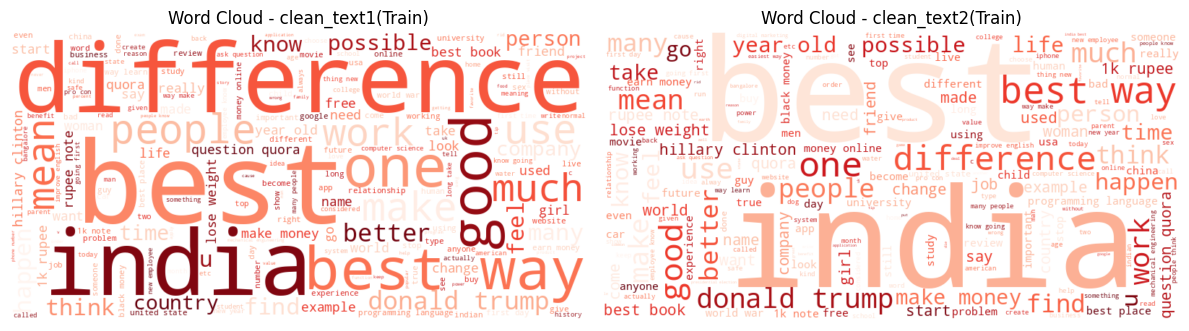

In [ ]:
# Join tokens to form strings
clean_text1_str1 = [' '.join(tokens) for tokens in X_train['clean_text1']]
clean_text2_str1 = [' '.join(tokens) for tokens in X_train['clean_text2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text1_str1))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text2_str1))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - clean_text1(Train)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - clean_text2(Train)")
plt.axis("off")

plt.tight_layout()
plt.show()


**Test**

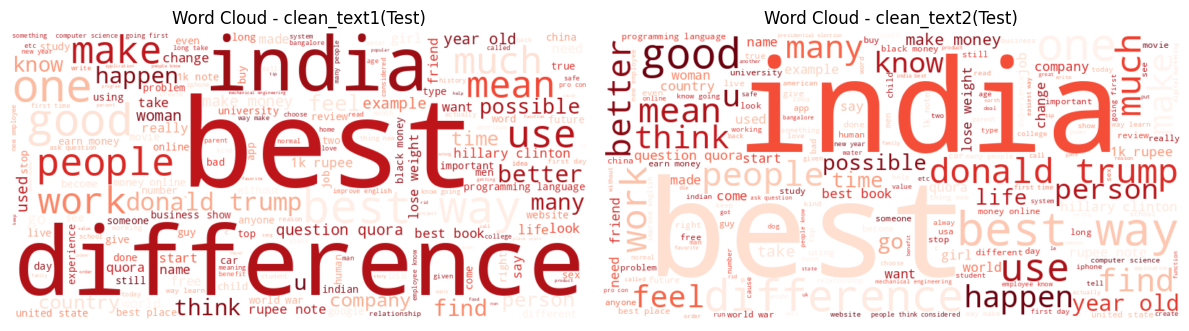

In [ ]:
# Join tokens to form strings
clean_text1_str2 = [' '.join(tokens) for tokens in X_test['clean_text1']]
clean_text2_str2 = [' '.join(tokens) for tokens in X_test['clean_text2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text1_str1))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text2_str1))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - clean_text1(Test)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - clean_text2(Test)")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Feature Extraction**

In [ ]:
# Define a function that extracts features from the questions 

import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def calculate_features(data):
    features = []

    for index, row in data.iterrows():
        question1 = str(row['question1'])
        question2 = str(row['question2'])

        # Sentence count
        sentence_count1 = len(sent_tokenize(question1))
        sentence_count2 = len(sent_tokenize(question2))

        # Percentage of common tokens
        tokens1 = word_tokenize(question1)
        tokens2 = word_tokenize(question2)
        common_tokens = len(set(tokens1) & set(tokens2))
        percentage_common_tokens = common_tokens / min(len(tokens1), len(tokens2))

        # Number of capital letters & Number of question marks
        num_capital_letters1 = sum(1 for char in question1 if char.isupper())
        num_capital_letters2 = sum(1 for char in question2 if char.isupper())
        num_question_marks1 = question1.count('?')
        num_question_marks2 = question2.count('?')

        # If questions start with are, can, how
        starts_with_are = question1.lower().startswith('are') or question2.lower().startswith('are')
        starts_with_can = question1.lower().startswith('can') or question2.lower().startswith('can')
        starts_with_how = question1.lower().startswith('how') or question2.lower().startswith('how')

        feature_row = [percentage_common_tokens, sentence_count1, sentence_count2, num_capital_letters1, num_capital_letters2,
                       num_question_marks1, num_question_marks2, starts_with_are, starts_with_can, starts_with_how]

        features.append(feature_row)
    return features

X_train_features = calculate_features(X_train)
feature_columns = ['percentage_common_tokens', 'sentence_count1', 'sentence_count2', 'num_capital_letters1', 'num_capital_letters2',
                   'num_question_marks1', 'num_question_marks2', 'starts_with_are', 'starts_with_can', 'starts_with_how']

X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)

X_train[['starts_with_are', 'starts_with_can', 'starts_with_how']] = X_train[['starts_with_are', 'starts_with_can', 'starts_with_how']].astype(int)
X_test[['starts_with_are', 'starts_with_can', 'starts_with_how']] = X_test[['starts_with_are', 'starts_with_can', 'starts_with_how']].astype(int)


In [ ]:
# Sample of the extracted features

X_train.sample(3)

,question1,question2,question1_len,question2_len,question_len_diff,clean_text1,clean_text2,percentage_common_tokens,question1_length,question2_length,...,percentage_common_tokens,sentence_count1,sentence_count2,num_capital_letters1,num_capital_letters2,num_question_marks1,num_question_marks2,starts_with_are,starts_with_can,starts_with_how
285634,I chose my ex over a girl I like very much and...,I am in love with a girl. I can sense she also...,147,183,36,"[chose, ex, girl, like, much, regret, need, ba...","[love, girl, sense, also, like, much, say, get...",0.410256,147,183,...,0.410256,2,3,5,5,1,1,0,0,0
49080,Can we control our feelings?,Does our mind control our emotions?,28,35,7,"[control, feeling]","[mind, control, emotion]",0.500000,28,35,...,0.500000,1,1,1,1,1,1,0,0,1
252223,Will Vietnam host a permanent US military base...,"As a software engineer, what's the best skill ...",68,82,14,"[vietnam, host, permanent, u, military, base, ...","[software, engineer, best, skill, set, next, 5...",0.357143,68,82,...,0.357143,1,1,4,1,1,1,0,0,0


In [ ]:
gc.collect()

310

In [ ]:
# A function that extracts features from generated tokens 'clean_text1' and 'clean_text2'

def calculate_features2(data):

    features = []

    for index, row in data.iterrows():
        text1 = row['clean_text1']
        text2 = row['clean_text2']

        word_count1, word_count2 = len(text1), len(text2)
        avg_word_length1 = sum(len(word) for word in text1) / len(text1) if len(text1) > 0 else 0
        avg_word_length2 = sum(len(word) for word in text2) / len(text2) if len(text2) > 0 else 0

        unique_word_count = len(set(text1).union(set(text2)))
        similar_word_count = len(set(text1).intersection(set(text2)))

        fuzzy_word_partial_ratio = fuzz.partial_ratio(' '.join(text1), ' '.join(text2))
        token_set_ratio = fuzz.token_set_ratio(' '.join(text1), ' '.join(text2))
        token_sort_ratio = fuzz.token_sort_ratio(' '.join(text1), ' '.join(text2))

        unique_words1 = set(text1)
        unique_words2 = set(text2)
        intersection = unique_words1.intersection(unique_words2)
        denominator = len(unique_words1) + len(unique_words2)
        word_overlap = len(intersection) / denominator if denominator > 0 else 0
        jaccard_similarity = len(intersection) / (len(unique_words1.union(unique_words2))) if denominator > 0 else 0

        levenshtein_distance = fuzz.ratio(' '.join(text1), ' '.join(text2))


        feature_row = [word_count1, word_count2, avg_word_length1,
                                 avg_word_length2, unique_word_count, similar_word_count, fuzzy_word_partial_ratio,
                                 token_set_ratio, token_sort_ratio, word_overlap, jaccard_similarity,
                                 levenshtein_distance]
        features.append(feature_row)

    return features

feature_columns = ['word_count1', 'word_count2', 'avg_word_length1',
                       'avg_word_length2', 'unique_word_count', 'similar_word_count', 'fuzzy_word_partial_ratio',
                       'token_set_ratio', 'token_sort_ratio', 'word_overlap', 'jaccard_similarity',
                       'levenshtein_distance']

X_train_features = calculate_features2(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features2(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)

In [ ]:
# Sample of extracted features

X_test[['word_count1', 'word_count2', 'avg_word_length1', 'avg_word_length2', 'unique_word_count',
        'similar_word_count', 'fuzzy_word_partial_ratio','token_set_ratio', 'token_sort_ratio', 
        'word_overlap', 'jaccard_similarity', 'levenshtein_distance']].sample(3)

,word_count1,word_count2,avg_word_length1,avg_word_length2,unique_word_count,similar_word_count,fuzzy_word_partial_ratio,token_set_ratio,token_sort_ratio,word_overlap,jaccard_similarity,levenshtein_distance
50497,6,6,5.00,5.666667,9,2,37,64,49,0.181818,0.222222,35
1487,6,3,5.50,7.666667,7,2,52,68,54,0.222222,0.285714,51
39185,4,5,8.25,8.800000,7,2,67,69,64,0.222222,0.285714,60


In [ ]:
# A function that extracts additional features

def average_word_frequency(text):
    freq_dist = FreqDist(text)
    total_frequency = sum(freq_dist.values())
    return total_frequency / (len(text) + 0.001)

def calculate_features3(data):
    features = []

    for index, row in data.iterrows():
        text1 = row['clean_text1']
        text2 = row['clean_text2']

        length_ratio = len(text1) / len(text2) if len(text2) != 0 else 0

        ngrams2 = set(ngrams(text2, 2))
        common_2grams = len(set(ngrams(text1, 2)).intersection(ngrams2)) / len(ngrams2) if len(ngrams2) != 0 else 0

        ngrams2 = set(ngrams(text2, 3))
        common_3grams = len(set(ngrams(text1, 3)).intersection(ngrams2)) / len(ngrams2) if len(ngrams2) != 0 else 0

        average_word_frequency1 = average_word_frequency(text1)
        average_word_frequency2 = average_word_frequency(text2)
        average_word_frequency_diff = average_word_frequency1 - average_word_frequency2

        feature_row = [length_ratio, common_2grams, common_3grams, average_word_frequency1, average_word_frequency2,
                       average_word_frequency_diff]

        features.append(feature_row)

    return features

feature_columns = ['length_ratio', 'common_2grams', 'common_3grams', 'average_word_frequency1', 'average_word_frequency2',
                   'average_word_frequency_diff']

X_train_features = calculate_features3(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features3(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)


In [ ]:
# Sample of extracted features 

X_train[['length_ratio', 'common_2grams', 'common_3grams', 'average_word_frequency1', 'average_word_frequency2',
                   'average_word_frequency_diff']].sample(3)

,length_ratio,common_2grams,common_3grams,average_word_frequency1,average_word_frequency2,average_word_frequency_diff
275151,0.75,0.666667,0.5,0.999667,0.999750,-0.000083
173751,1.00,0.833333,0.8,0.999857,0.999857,0.000000
175465,2.00,1.000000,0.0,0.999750,0.999500,0.000250


In [ ]:
X_train.head()

,question1,question2,question1_len,question2_len,question_len_diff,clean_text1,clean_text2,percentage_common_tokens,question1_length,question2_length,...,token_sort_ratio,word_overlap,jaccard_similarity,levenshtein_distance,length_ratio,common_2grams,common_3grams,average_word_frequency1,average_word_frequency2,average_word_frequency_diff
0,What do you think about Nicki Minaj?,What is the appeal of Nicki Minaj?,36,34,2,"[think, nicki, minaj]","[appeal, nicki, minaj]",0.500000,36,34,...,63,0.333333,0.500000,69,1.000000,0.50,0.000000,0.999667,0.999667,0.000000
1,"Do atheists believe in palmistry, numerology, ...",Do some atheists believe in astrology?,62,38,24,"[atheist, believe, palmistry, numerology, astr...","[atheist, believe, astrology]",0.857143,62,38,...,67,0.333333,0.500000,67,2.000000,0.50,0.000000,0.999833,0.999667,0.000167
2,Where can I gain a SAFe agilist certification ...,"How safe is it to live in Fulham, London?",56,41,15,"[gain, safe, agilist, certification, london]","[safe, live, fulham, london]",0.272727,56,41,...,52,0.222222,0.285714,56,1.250000,0.00,0.000000,0.999800,0.999750,0.000050
3,What are the biggest challenges for real estat...,Is it good to switch off the Wi-Fi Hotspot aft...,111,58,53,"[biggest, challenge, real, estate, agent, righ...","[good, switch, wi, fi, hotspot, using]",0.230769,111,58,...,27,0.000000,0.000000,34,1.333333,0.00,0.000000,0.999875,0.999833,0.000042
4,What are the strongest majors in terms of job ...,What are the strongest majors in terms of job ...,105,106,1,"[strongest, major, term, job, prospect, weakes...","[strongest, major, term, job, prospect, weakes...",0.800000,105,106,...,89,0.437500,0.777778,94,1.000000,0.75,0.714286,0.999889,0.999889,0.000000


In [ ]:
# Reset the indices of X_train and y_train
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Concatenate X_train with y_train
train_df = pd.concat([X_train, y_train], axis=1)

# Reset the indices of X_test and y_test
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Concatenate X_test with y_test
test_df = pd.concat([X_test, y_test], axis=1)

### **Save train and test**

In [ ]:
train_path = '/content/drive/MyDrive/clean_data_traindf.csv'
test_path = '/content/drive/MyDrive/clean_data_test.csv'
train_df.to_csv('traindf', index=False)
test_df.to_csv('testdf', index=False)